In [16]:
from backtest.repository.finance.finance_repo import FinanceRepo
%load_ext autoreload
%autoreload 2

from backtest.domains.stockdata import StockData
from backtest.domains.strategy import Strategy
from backtest.domains.strategy_result import StrategyResult,StrategyResultColumnType
from backtest.domains.backtest import Backtest
from backtest.repository.webrepo.crypto.bithumb_repo import BithumbRepo
from backtest.repository.webrepo.crypto.upbit_repo import UpbitRepo
from backtest.repository.webrepo.crypto.binance_repo import BinanceRepo
from backtest.use_cases.stockdata_from_repo import stockdata_from_repo
from backtest.request.stockdata_from_repo import build_stock_data_from_repo_request
from backtest.use_cases.strategy_execute import sma_function, sma_big_stock_function, sma_multi_big_stock_function, greed_fear_index_function, rsi_function, rsi_big_stock_function
from backtest.use_cases.backtest_execute import backtest_execute
from backtest.util.stockdata_util import get_greed_fear_index
import pandas as pd

request = build_stock_data_from_repo_request(
    filters={'order__eq': 'ALGO', 'from__eq': '2019-01-01'})
response = stockdata_from_repo(BithumbRepo(), request=request,cache=True)

request2 = build_stock_data_from_repo_request(
    filters={'order__eq': 'BTC', 'from__eq': '2019-01-01'})
response2 = stockdata_from_repo(BithumbRepo(), request=request2, cache=True)

request3 = build_stock_data_from_repo_request(
    filters={'order__eq': 'ETC', 'from__eq': '2019-01-01'})
response3 = stockdata_from_repo(BithumbRepo(), request=request3,cache=True)

request4 = build_stock_data_from_repo_request(
    filters={'order__eq': 'US500', 'from__eq': '2019-11-01'})
response4 = stockdata_from_repo(FinanceRepo(), request=request4,cache=True)

request5 = build_stock_data_from_repo_request(
    filters={'order__eq': 'DOT', 'from__eq': '2019-01-01'})
response5 = stockdata_from_repo(BithumbRepo(), request=request5,cache=True)

stockdata1 = response.value
stockdata2 = response2.value
stockdata3 = response3.value
stockdata4 = response4.value
stockdata5 = response5.value

strategy1 = Strategy(name='snp_big_stock', function=sma_big_stock_function,
                    weight=3, options={'big_stock': stockdata4, 'rolling': 100})
strategy2 = Strategy(name='sma_big_stock', function=sma_big_stock_function,
                    weight=2, options={'big_stock': stockdata2, 'rolling': 90})
strategy3 = Strategy(name='sma_self', function=sma_function,
                    weight=1, options={'rolling': 10})
greed_fear_df = get_greed_fear_index()
strategy4 = Strategy(name='Greed_Fear_Index',function=greed_fear_index_function,
                    weight=1, options={'greed_fear_index_data': greed_fear_df,'index_fear' : 20,'index_greed':60})
strategy5 = Strategy(name='rsi_function',function=rsi_function,
                    weight=0.5, options={'period': 15,'overbought_level' : 30,'oversold_level': 70})
strategy6 = Strategy(name='rsi_big_stock_function',function=rsi_big_stock_function,
                    weight=0.5, options={'big_stock':stockdata4, 'period': 15,'overbought_level' : 30,'oversold_level':70})
strategy7 = Strategy(name='sma_multi_big_stock', function=sma_multi_big_stock_function,
                    weight=1, options={'big_stock': stockdata4, 'rolling_list': [100,15]})
strategy8 = Strategy(name='sma_multi_big_stock', function=sma_multi_big_stock_function,
                    weight=1, options={'big_stock': stockdata2, 'rolling_list': [100,15]})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


StockData(symbol='US500', data=                   open         high          low        close      volume
date                                                                      
2019-11-01  3050.719971  3066.949951  3050.719971  3066.909912  3956290000
2019-11-04  3078.959961  3085.199951  3074.870117  3078.270020  4178040000
2019-11-05  3080.800049  3083.949951  3072.149902  3074.620117  4490590000
2019-11-06  3075.100098  3078.340088  3065.889893  3076.780029  4465510000
2019-11-07  3087.020020  3097.770020  3080.229980  3085.179932  4151990000
...                 ...          ...          ...          ...         ...
2023-04-13  4100.040039  4150.259766  4099.399902  4146.220215  3596590000
2023-04-14  4140.109863  4163.189941  4113.200195  4137.640137  3575690000
2023-04-17  4137.169922  4151.720215  4123.180176  4151.319824  3611180000
2023-04-18  4164.259766  4169.479980  4140.359863  4154.870117  3536640000
2023-04-19  4139.330078  4162.569824  4134.490234  4154.520020  35725

In [181]:
backtest = Backtest(strategy_list=[strategy1,strategy2,strategy3,strategy4,strategy5,strategy6,strategy7,strategy8], stockdata_list=[stockdata3,stockdata5])
backtest_result = backtest_execute(backtest).value
backtest_result.value
df=backtest_result.value['total_profit'].expanding().sum()
df

date
2019-01-01    0.000000
2019-01-02    0.000000
2019-01-03    0.000000
2019-01-04    0.000000
2019-01-05    0.000000
                ...   
2023-04-05    4.701043
2023-04-06    4.701043
2023-04-07    4.701043
2023-04-08    4.701043
2023-04-09    4.701043
Freq: D, Name: total_profit, Length: 1560, dtype: float64

In [182]:
backtest_result.value['total_profit'].min()

-0.096255488293015

In [109]:
backtest_result.value.to_csv('sample.csv')

In [171]:
def calculate_rsi(data, period):
    delta = data.diff().dropna()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


df=stockdata5.data
df['RSI']=calculate_rsi(df['close'],14)
def _rsi_function(r):
    if r <= 70 and r > 70:
        return (StrategyResultColumnType.BUY, 1)
    elif r >= 30 and r < 30:
        return (StrategyResultColumnType.SELL, 1)
    else:
        return (StrategyResultColumnType.KEEP, 1)
result=df.apply(lambda r:_rsi_function(r['close']),axis=1)

In [113]:
%load_ext autoreload
%autoreload 2
from backtest.request.selector_reference_from_repo import build_selector_reference_from_repo_request
from backtest.repository.webrepo.crypto.coingecko_repo import CoinGeckoRepo
from backtest.use_cases.selector_reference_from_repo import selector_reference_from_repo

request = build_selector_reference_from_repo_request(filters={'symbol__eq':'BTC'})
result = selector_reference_from_repo(CoinGeckoRepo(),request,cache=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
import pandas as pd
from backtest.use_cases.make_crypto_backtest import make_crypto_selector_reference_makretcap,MarketType

response = make_crypto_selector_reference_makretcap(MarketType.BITHUMB,from_date='2017-01-01',cache=True)
rank_df = response.value.data.apply(lambda x: x[x != 0].rank(),axis=1)
def sample_function(r:pd.Series):
    return list(r.dropna().nlargest(10).index)
rank_top10 = rank.apply(lambda r :  sample_function(r),axis=1)
rank_top10.to_csv('sample.csv')

<Axes: xlabel='date'>

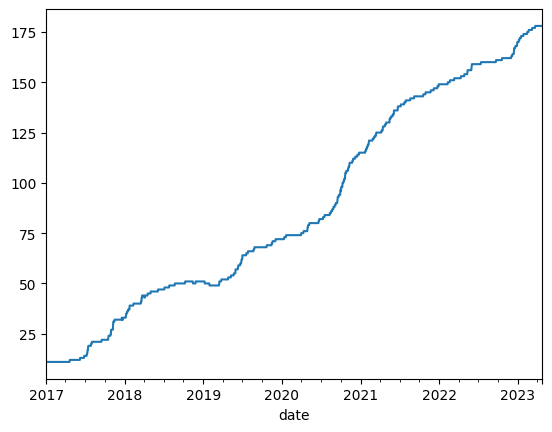

In [141]:
rank_df['BTC'].plot()